In [1]:
import cobra

In [2]:
# load base iJO1366 model
model_ijo = cobra.io.read_sbml_model('models/iJO1366.xml')

In [3]:
# load eciJ01366 model
model_ec = cobra.io.read_sbml_model('models/iJO1366star.xml')

## Model Inspection

We need to understand what's in each model before running simulations. Key things to identify:
- **Biomass reaction**: The objective function that represents cell growth
- **Exchange reactions**: Allow metabolites to enter/leave the system (glucose in, acetate out, oxygen in, etc.)
- **Protein pool constraint** (in iJO1366*): The enzyme capacity limitation that makes this an enzyme-constrained model

The enzyme-constrained model (iJO1366*) was generated using AutoPACMEN/sMOMENT. It adds a "protein pool" pseudo-metabolite that limits total enzyme usage based on molecular weights and turnover numbers (kcat).


In [4]:
model_ijo


Name,iJO1366
Memory address,7fe78e1d0580
Number of metabolites,1805
Number of reactions,2583
Number of genes,1367
Number of groups,37
Objective expression,1.0*BIOMASS_Ec_iJO1366_core_53p95M - 1.0*BIOMASS_Ec_iJO1366_core_53p95M_reverse_5c8b1
Compartments,"cytosol, extracellular space, periplasm"


In [5]:
model_ec

Name,iJO1366
Memory address,7fe78dc4a800
Number of metabolites,1806
Number of reactions,3178
Number of genes,1367
Number of groups,37
Objective expression,1.0*BIOMASS_Ec_iJO1366_core_53p95M - 1.0*BIOMASS_Ec_iJO1366_core_53p95M_reverse_5c8b1
Compartments,"cytosol, extracellular space, periplasm, ThermoGecko"


In [6]:
sames = []
diffs = []
for rxn in model_ijo.reactions:
    if rxn.id in model_ec.reactions:
        sames.append(rxn.id)
    else:
        diffs.append(rxn.id)
print(f"Number of reactions in both models: {len(sames)}")
print(f"Number of reactions in iJO1366 but not iJO1366*: {len(diffs)}")




Number of reactions in both models: 1989
Number of reactions in iJO1366 but not iJO1366*: 594


In [7]:
print(sorted(sames))
print(sorted(diffs))

['12DGR120tipp', '12DGR140tipp', '12DGR141tipp', '12DGR160tipp', '12DGR161tipp', '12DGR180tipp', '12DGR181tipp', '12PPDRtpp', '12PPDStpp', '14GLUCANabcpp', '14GLUCANtexi', '23DAPPAt2pp', '23PDE2pp', '23PDE4pp', '23PDE7pp', '23PDE9pp', '2AGPA120tipp', '2AGPA140tipp', '2AGPA141tipp', '2AGPA160tipp', '2AGPA161tipp', '2AGPA180tipp', '2AGPA181tipp', '2AGPE120tipp', '2AGPE140tipp', '2AGPE141tipp', '2AGPE160tipp', '2AGPE161tipp', '2AGPE180tipp', '2AGPE181tipp', '2AGPEAT120', '2AGPEAT140', '2AGPEAT141', '2AGPEAT160', '2AGPEAT161', '2AGPEAT180', '2AGPEAT181', '2AGPG120tipp', '2AGPG140tipp', '2AGPG141tipp', '2AGPG160tipp', '2AGPG161tipp', '2AGPG180tipp', '2AGPG181tipp', '2AGPGAT120', '2AGPGAT140', '2AGPGAT141', '2AGPGAT160', '2AGPGAT161', '2AGPGAT180', '2AGPGAT181', '2DGULRGx', '2DGULRGy', '2DGULRx', '2DGULRy', '2MAHMP', '3AMACHYD', '3HAD100', '3HAD120', '3HAD121', '3HAD140', '3HAD141', '3HAD160', '3HAD161', '3HAD180', '3HAD181', '3HAD40', '3HAD60', '3HAD80', '3HCINNMH', '3HPPPNH', '3HPPtpp', '3

In [8]:
ec_rxns = []

for rxn in model_ec.reactions:
    if rxn.id not in sames and rxn.id not in diffs:
        ec_rxns.append(rxn.id)

print(len(ec_rxns))
print(sorted(ec_rxns))


1189
['12PPDRtex_TG_forward', '12PPDRtex_TG_reverse', '12PPDStex_TG_forward', '12PPDStex_TG_reverse', '23CAMPtex_TG_forward', '23CAMPtex_TG_reverse', '23CCMPtex_TG_forward', '23CCMPtex_TG_reverse', '23CGMPtex_TG_forward', '23CGMPtex_TG_reverse', '23CUMPtex_TG_forward', '23CUMPtex_TG_reverse', '23DAPPAtex_TG_forward', '23DAPPAtex_TG_reverse', '26DAHtex_TG_forward', '26DAHtex_TG_reverse', '34dhpactex_TG_forward', '34dhpactex_TG_reverse', '3AMPtex_TG_forward', '3AMPtex_TG_reverse', '3CMPtex_TG_forward', '3CMPtex_TG_reverse', '3GMPtex_TG_forward', '3GMPtex_TG_reverse', '3HPPtex_TG_forward', '3HPPtex_TG_reverse', '3OAR100_TG_forward', '3OAR100_TG_reverse', '3OAR120_TG_forward', '3OAR120_TG_reverse', '3OAR140_TG_forward', '3OAR140_TG_reverse', '3OAR160_TG_forward', '3OAR160_TG_reverse', '3OAR180_TG_forward', '3OAR180_TG_reverse', '3OAR40_TG_forward', '3OAR40_TG_reverse', '3OAR60_TG_forward', '3OAR60_TG_reverse', '3OAR80_TG_forward', '3OAR80_TG_reverse', '3PEPTtex_TG_forward', '3PEPTtex_TG_re

In [9]:
for rxn in ec_rxns:
    if 'forward' not in rxn and 'reverse' not in rxn:
        print(rxn)


ER_pool_TG_


There are 594 reactions from the base model that are not in the ec model because they were split into forward and reverse reactions (594 x 2 = 1188) and a pool reaction representing total enzyme amounts was included. 

In [10]:
print("=== Compare objective funtions ===")
print(f"iJO1366 objective: {model_ijo.objective.expression}")
print(f"iJO1366* objective: {model_ec.objective.expression}")

print("\n=== base biomass bounds ===")
for rxn in model_ijo.reactions:
    if 'biomass' in rxn.id.lower() or rxn.objective_coefficient != 0:
        print(f"{rxn.id}: bounds=({rxn.lower_bound}, {rxn.upper_bound}), obj_coeff={rxn.objective_coefficient}")

print("\n=== ec biomass bounds ===")
for rxn in model_ec.reactions:
    if 'biomass' in rxn.id.lower() or rxn.objective_coefficient != 0:
        print(f"{rxn.id}: bounds=({rxn.lower_bound}, {rxn.upper_bound}), obj_coeff={rxn.objective_coefficient}")


=== Compare objective funtions ===
iJO1366 objective: 1.0*BIOMASS_Ec_iJO1366_core_53p95M - 1.0*BIOMASS_Ec_iJO1366_core_53p95M_reverse_5c8b1
iJO1366* objective: 1.0*BIOMASS_Ec_iJO1366_core_53p95M - 1.0*BIOMASS_Ec_iJO1366_core_53p95M_reverse_5c8b1

=== base biomass bounds ===
BIOMASS_Ec_iJO1366_WT_53p95M: bounds=(0.0, 1000.0), obj_coeff=0.0
BIOMASS_Ec_iJO1366_core_53p95M: bounds=(0.0, 1000.0), obj_coeff=1.0

=== ec biomass bounds ===
BIOMASS_Ec_iJO1366_WT_53p95M: bounds=(0.0, 0.0), obj_coeff=0.0
BIOMASS_Ec_iJO1366_core_53p95M: bounds=(0.0, 1000.0), obj_coeff=1.0


There are two available growth functions available to both models. The objective function is set by the obj_coeff or by zeroing out the bounds. Both of the models have the core (as opposed to WT) growth functions set as the objective. 

In [11]:
key_metabolites = ['_glc',  '_ac_', '_o2', 'dha','co2', 'lac', 'pyr'] # from article
key_met_rxns = {}
print("Key exchange reactions in iJO1366*:")
print("-" * 60)

for met in key_metabolites:
    for rxn in model_ec.exchanges:
        if met.lower() in rxn.id.lower():
            print(f"{rxn.id:30} | bounds: ({rxn.lower_bound:8.1f}, {rxn.upper_bound:8.1f})")
            key_met_rxns[rxn.id] = (rxn.lower_bound, rxn.upper_bound)
            break


Key exchange reactions in iJO1366*:
------------------------------------------------------------
EX_glc__D_e                    | bounds: (     0.0,   1000.0)
EX_ac_e                        | bounds: (     0.0,   1000.0)
EX_o2_e                        | bounds: ( -1000.0,   1000.0)
EX_dha_e                       | bounds: (     0.0,      0.0)
EX_co2_e                       | bounds: ( -1000.0,   1000.0)
EX_lac__D_e                    | bounds: (     0.0,   1000.0)
EX_pyr_e                       | bounds: (     0.0,      0.0)


In [12]:
key_metabolites = ['_glc',  '_ac_', '_o2', 'dha','co2', 'lac', 'pyr'] # from article
base_key_met_rxns = {}
print("Key exchange reactions in iJO1366*:")
print("-" * 60)

for met in key_metabolites:
    for rxn in model_ijo.exchanges:
        if met.lower() in rxn.id.lower():
            print(f"{rxn.id:30} | bounds: ({rxn.lower_bound:8.1f}, {rxn.upper_bound:8.1f})")
            base_key_met_rxns[rxn.id] = (rxn.lower_bound, rxn.upper_bound)
            break

Key exchange reactions in iJO1366*:
------------------------------------------------------------
EX_glc__D_e                    | bounds: (   -10.0,   1000.0)
EX_ac_e                        | bounds: (     0.0,   1000.0)
EX_o2_e                        | bounds: ( -1000.0,   1000.0)
EX_dha_e                       | bounds: (     0.0,   1000.0)
EX_co2_e                       | bounds: ( -1000.0,   1000.0)
EX_lac__D_e                    | bounds: (     0.0,   1000.0)
EX_pyr_e                       | bounds: (     0.0,   1000.0)


In [13]:
# reactions can be viewed by the following:
model_ec.reactions.get_by_id('EX_ac_e')

Reaction identifier,EX_ac_e
Name,Acetate exchange
Memory address,0x7fe78c1d93f0
Stoichiometry,ac_e --> Acetate -->
GPR,
Lower bound,0.0
Upper bound,1000.0


### Finding the Protein Pool Constraint

The protein pool is the key feature that makes this an enzyme-constrained model. In sMOMENT/AutoPACMEN models, there's typically a pseudo-metabolite called something like `prot_pool` that constrains the total enzyme mass available. The reaction that produces this metabolite has an upper bound representing the maximum cellular enzyme capacity.


In [14]:
print("Searching for protein pool metabolite...")
prot_pool_met = None
for met in model_ec.metabolites:
    if 'pool' in met.id.lower() or 'pool' in met.id.lower():
        prot_pool_met = met
        print(f"Found: {met.id} - {met.name}")
        print(f"Compartment: {met.compartment}")
        print(f"Reactions using this metabolite: {len(met.reactions)}")
        break

if prot_pool_met is None:
    print("No obvious protein pool found - let's check for sMOMENT-style naming")


Searching for protein pool metabolite...
Found: prot_pool - prot_pool pseudometabolite for unmeasured proteins
Compartment: ThermoGecko
Reactions using this metabolite: 2637


In [15]:
if prot_pool_met:
    print(f"\nReactions involving {prot_pool_met.id}:")
    print("-" * 80)
    
    prot_pool_rxn = None
    for rxn in prot_pool_met.reactions:
        coeff = rxn.get_coefficient(prot_pool_met.id)
        if coeff > 0:
            prot_pool_rxn = rxn
            print(f"PROTEIN POOL SUPPLY: {rxn.id}")
            print(f"  Bounds: ({rxn.lower_bound}, {rxn.upper_bound})")
            print(f"  --> This is the constraint limiting total enzyme capacity")
            break
    
    print(f"\nFirst 5 enzyme-using reactions (sample):")
    count = 0
    for rxn in prot_pool_met.reactions:
        coeff = rxn.get_coefficient(prot_pool_met.id)
        if coeff < 0 and count < 5:
            print(f"  {rxn.id}: coefficient = {coeff:.6f}")
            count += 1



Reactions involving prot_pool:
--------------------------------------------------------------------------------
PROTEIN POOL SUPPLY: ER_pool_TG_
  Bounds: (0.0, 0.095)
  --> This is the constraint limiting total enzyme capacity

First 5 enzyme-using reactions (sample):
  I2FE2ST: coefficient = -0.000063
  NTP1: coefficient = -0.001065
  SO4tex_TG_reverse: coefficient = -0.000023
  UDPGALtex_TG_reverse: coefficient = -0.000023
  SDPTA_TG_forward: coefficient = -0.000897


(From Paper) Before tuning, all exchange reaction bounds were set to ±1000 mmol/gCDW/h


In [16]:
for rxn in model_ec.reactions: 
    if 'EX' in rxn.id:
        rxn.lower_bound = -1000.0
        rxn.upper_bound = 1000.0

### Sanity Check: Run FBA on Both Models

Let's verify both models solve correctly and compare their maximum growth rates. The enzyme-constrained model should have a lower (or equal) growth rate than the base model.


In [17]:
sol_ijo = model_ijo.optimize()
sol_ec = model_ec.optimize()

print("FBA Results (default conditions):")
print("-" * 40)
print(f"iJO1366 (base):              μ = {sol_ijo.objective_value:.4f} h⁻¹")
print(f"iJO1366* (enzyme-constrained): μ = {sol_ec.objective_value:.4f} h⁻¹")
print(f"\nStatus: iJO1366={sol_ijo.status}, iJO1366*={sol_ec.status}")


FBA Results (default conditions):
----------------------------------------
iJO1366 (base):              μ = 0.9824 h⁻¹
iJO1366* (enzyme-constrained): μ = 13.0509 h⁻¹

Status: iJO1366=optimal, iJO1366*=optimal


## Experimental Data
**S1.xlsx and S4.xlsx** contain the supplemental data from the article
- **S1.xlsx** contains the medium composition - initial concentrations of nutrients in the bioreactor.
- **S4.xlsx** contains the fermentation time-series data - the experimental measurements of biomass and key metabolites over time. 
    - SamplingAndAdditions sheet contains Dry Weight measurement
        - paper reports that sampling volume was 10 mg
    - Medium sheet contains metabolite data
        - glucose 
        - acetate
    - --> These 3 are plotted in the paper in fig 2


In [18]:
import pandas as pd

In [119]:
df_medium = pd.read_csv('data/m9_fermCL.csv',header = 0, sep = ';')
print("=== m9 Medium Composition ===")
print(f"Shape: {df_medium.shape}")
df_medium.head(25)


=== m9 Medium Composition ===
Shape: (25, 3)


,exchange_reaction_id,exchange_reaction_name,concentration_mmol_per_liter
0,EX_ca2_e,Calcium exchange,0.027200
1,EX_cbl1_e,Cob(I)alamin exchange,0.000000
2,EX_cl_e,Chloride exchange,120.761400
3,EX_co2_e,CO2 exchange,0.000000
4,EX_cobalt2_e,Co2+ exchange,0.001440
5,EX_cu2_e,Cu2+ exchange,0.048160
6,EX_fe2_e,Fe2+ exchange,0.287760
7,EX_fe3_e,Fe3+ exchange,0.000000
8,EX_glc__D_e,D-Glucose exchange,111.111110
9,EX_h_e,H+ exchange,77.700000


In [360]:
ferm_sampling = pd.read_excel('data/S4.xlsx', sheet_name='SamplingAndAdditions')
print("=== S4: Fermentation Data ===")
print(f"Shape: {ferm_sampling.shape}")
ferm_sampling.tail(5)


=== S4: Fermentation Data ===
Shape: (26, 11)


,Time,Time (h),OD600nm,Alu-pan (mg),Total (mg),Dry weight (mg),NaOH (ml),Cryo-tube #,Aluminum pan #,Volume removed from fermenter (ml),Unnamed: 10
21,19:00:00,10.5,24.4,1722.50,1803.01,NaN,40,22,17.0,15,NaN
22,19:30:00,11.0,23.7,1732.09,1819.65,NaN,40,23,18.0,15,NaN
23,20:00:00,11.5,25.3,1740.59,1828.00,87.41,40,24,19.0,15,NaN
24,20:30:00,12.0,21.6,NaN,NaN,NaN,40,25,NaN,5,NaN
25,21:00:00,12.5,23.3,1743.13,1825.50,82.37,40,26,20.0,15,NaN


In [249]:
dry_weight = ferm_sampling[['Time', 'OD600nm', 'Time (h)', 'Dry weight (mg)']]
dry_weight.columns = ['Real Time', 'OD600nm', 'Time', 'DW']
dry_weight['DW'] = dry_weight['DW']/10
dry_weight.head(5)

/tmp/ipykernel_3901/2230482403.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dry_weight['DW'] = dry_weight['DW']/10


,Real Time,OD600nm,Time,DW
0,08:30:00,0.180,0.0,NaN
1,09:00:00,0.212,0.5,NaN
2,09:30:00,0.249,1.0,NaN
3,10:00:00,0.344,1.5,NaN
4,10:30:00,0.417,2.0,0.336


In [250]:
ferm_medium = pd.read_excel('data/S4.xlsx', sheet_name='Medium')
ferm_medium.drop(['Before incoulation','HMDB ID'], axis=1, inplace=True)
print("=== S4: Fermentation Data ===")
print(f"Shape: {ferm_medium.shape}")
ferm_medium.head(5)

=== S4: Fermentation Data ===
Shape: (18, 27)


,Compound,0,0.5,1,1.5,2,2.5,3,3.5,4,...,8,8.5,9,9.5,10,10.5,11,11.5,12,12.5
0,Formate,0.020234,0.017863,0.097349,0.017026,0.016787,0.019052,0.084743,0.073919,0.206910,...,2.485290,0.618097,0.143151,0.024320,0.017295,0.012253,0.013429,0.014024,0.013453,0.014479
1,Uracil,0.017982,0.000000,0.000000,0.000000,0.012472,0.010665,0.013735,0.000000,0.011859,...,0.066513,0.286570,0.355364,0.401497,0.502872,0.531856,0.537275,0.615962,0.661168,0.676991
2,N-Carbamoylaspartate?,0.000000,0.014204,0.016410,0.018877,0.020361,0.019931,0.022650,0.021954,0.022451,...,0.036390,0.081062,0.088307,0.086080,0.090321,0.078719,0.067284,0.078848,0.077722,0.087370
3,Orotate,0.014686,0.018133,0.027876,0.032037,0.040328,0.051333,0.072621,0.096974,0.148756,...,1.995313,2.499116,2.377328,1.930174,1.515549,1.739597,1.097640,1.437814,0.576544,0.514050
4,Uracil,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.059158,0.274496,0.338123,0.347592,0.437324,0.491355,0.517603,0.600544,0.665135,0.591567


In [251]:
f_medium = ferm_medium.set_index('Compound').T
f_medium.rename_axis('Time', inplace=True)
f_medium.reset_index(inplace=True)
f_medium.columns.name = None
f_medium.head(5)

,Time,Formate,Uracil,N-Carbamoylaspartate?,Orotate,Uracil,α-Glucose,"1,3-Dihydroxyacetone",Ethanol,Glucose,N-Carbamoylaspartate 1 ?,Citrate ?,Succinate,Pyruvare,Propionate,N-Acetylaspartate?,Acetate,Ethanol 1,TSP
0,0.0,0.020234,0.017982,0.000000,0.014686,0.0,131.092022,0.0,5.706077,90.361871,0.032462,0.012038,0.0,0.0,0.0,0.010281,0.109581,5.004277,4.832529
1,0.5,0.017863,0.000000,0.014204,0.018133,0.0,131.201962,0.0,6.084290,90.426675,0.049870,0.011153,0.0,0.0,0.0,0.000000,0.187293,5.436320,4.832529
2,1.0,0.097349,0.000000,0.016410,0.027876,0.0,129.898388,0.0,6.339788,89.570737,0.041201,0.013339,0.0,0.0,0.0,0.013353,0.468511,5.629007,4.832529
3,1.5,0.017026,0.000000,0.018877,0.032037,0.0,128.878724,0.0,6.142418,88.672612,0.043830,0.013736,0.0,0.0,0.0,0.015185,0.587278,5.465982,4.832529
4,2.0,0.016787,0.012472,0.020361,0.040328,0.0,124.247953,0.0,5.825921,85.320624,0.040337,0.013820,0.0,0.0,0.0,0.016618,0.872368,5.201198,4.832529


In [262]:
conc_df = f_medium[['Time', 'Glucose', 'Acetate']]
conc_df.columns = ['Time',  'Glucose', 'Acetate']
conc_df.tail(5)

,Time,Glucose,Acetate
21,10.5,0.190881,0.034206
22,11.0,0.220647,0.038401
23,11.5,0.245288,0.034070
24,12.0,0.267304,0.036958
25,12.5,0.270651,0.038127


In [263]:
# Add dry weight data to concentration dataframe
exp_data = conc_df.merge(dry_weight[['Time', 'DW']], on='Time', how='left')
exp_data.head(20)

,Time,Glucose,Acetate,DW
0,0.0,90.361871,0.109581,NaN
1,0.5,90.426675,0.187293,NaN
2,1.0,89.570737,0.468511,NaN
3,1.5,88.672612,0.587278,NaN
4,2.0,85.320624,0.872368,0.336
5,2.5,84.312897,1.243220,NaN
6,3.0,84.962679,1.892138,NaN
7,3.5,83.389981,2.455051,NaN
8,4.0,83.307779,3.354858,0.824
9,4.5,82.604936,4.160663,1.054


In [264]:
exp_data.to_csv('data/exp_data.csv', index=False)

In [25]:
import matplotlib.pyplot as plt

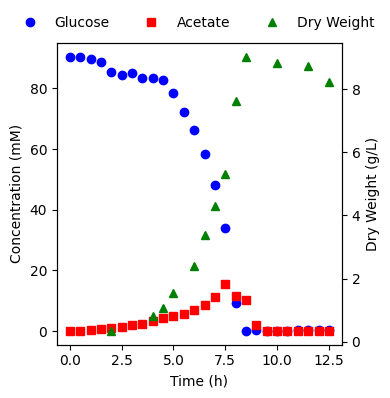

In [267]:
fig, ax1 = plt.subplots(figsize=(4, 4))

# Left y-axis: Glucose and Acetate
line1, = ax1.plot(exp_data['Time'], exp_data['Glucose'], 'bo',  label='Glucose')
line2, = ax1.plot(exp_data['Time'], exp_data['Acetate'], 'rs',  label='Acetate')
ax1.set_xlabel('Time (h)')
ax1.set_ylabel('Concentration (mM)')

# Right y-axis: Dry Weight
ax2 = ax1.twinx()
line3, = ax2.plot(exp_data['Time'], exp_data['DW'], 'g^',  label='Dry Weight')
ax2.set_ylabel('Dry Weight (g/L)')
ax2.tick_params(axis='y')

lines = [line1, line2, line3]
labels = [l.get_label() for l in lines]

fig.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, 1.0), 
           ncol=3, frameon=False)

plt.tight_layout()
plt.subplots_adjust(top=0.9) 
plt.show()

## dFBA Simulation 

Dynamic FBA works by iteratively:
1. **Set upper/lower bounds** for all uptake/exretion reactions based on current extracellular concentrations 
    - so uptake cannot exceed what remains in the medium
2. **Solve FBA** to get fluxes at this instant
3. **Update concentrations** by integrating fluxes over a small time step
4. **Repeat** until simulation end

The key equation connecting fluxes to concentration changes is:
$$\frac{dc_i}{dt} = v_i \cdot X$$

- $c_i (mmol/L=mM)$ - concentration of metabolite $i$
- $v_i (mmol/gDW/h)$ - mmol exchange of metabolite $i$ per g dry weight per hour
- $X (gDW/L)$ - grams dry weight of biomass concentration

For biomass itself:
$$\frac{dX}{dt} = \mu \cdot X$$

Where $\mu$ is the growth rate from FBA.

--> Initial Concentrations come from the fermentation data at t=0


**Acetate Overflwo**
Cells have a feedback mechanism where the don't keep exreting acetate at a constant maximal rate forever. Instead there is a feedback mechanism that decreases the amount of acete excretion as the extracellular concentration increases. 


**Initial Biomass**
There are no Biomass measurements before t=2, so my simulation will start from there. 

**Oxygen** uptake is set to 15 mmol/gDW/h in paper

**Prot_Pool** every reaction in the network consumes a pseudo-metabolite called prot_pool based on its molecular weight and tunrover number (MW/kcat)
- ER_pool_TG is the artificial supply reaction that provides this prot_pool "currency" to the system
- If this reaction is set to 0, the "budget" is zero and the model cannot run any reactions
- If set to 1000, the model behaves like standard FBA


In [33]:
model_ec.reactions.get_by_id('ER_pool_TG_')

Reaction identifier,ER_pool_TG_
Name,prot_pool reaction for unmeasured proteins
Memory address,0x7fe78ab54a30
Stoichiometry,--> prot_pool --> prot_pool pseudometabolite for unmeasured proteins
GPR,
Lower bound,0.0
Upper bound,0.095


In [288]:
initial_vals = {
    'biomass': exp_data['DW'][exp_data['Time'] == 2].iloc[0],
    'glucose': exp_data['Glucose'][exp_data['Time'] == 2].iloc[0],
    'acetate': exp_data['Acetate'][exp_data['Time'] == 2].iloc[0]
}

In [29]:
from dataclasses import dataclass
import math

In [310]:
@dataclass
class FermentationState:
    biomass: float # gDW/L
    glc: float # mM
    ac: float # mM

@dataclass
class SimParams:
    ac_feedback: bool
    vmax_ac_ex: float # mmol/gDW/h
    vmax_glc_ex: float # mmol/gDW/h
    glc_km: float # mM
    ac_feedback_k: float
    ec_constraints: bool
    dt: float # time step (h)
    
    

In [361]:
class dFBA:
    """
    Attributes after initialization:
    - base_model: original cobra model (never modified)
    - model: working copy for simulation
    - volume: culture volume (L)
    - t: current time (h)
    - state: current extracellular concentrations and biomass
    - history: list of dicts with time series records
    """

    def __init__(self, iJO1366star, volume = 1.0, media = df_medium, sim_params: SimParams = None):
        
        self.base_model = iJO1366star
        self.model = iJO1366star.copy()
        self.volume = volume
        self.params = sim_params
        self.media = media
        self.ex_tracker = []

        self.t = 0.0
        self.state = None        
        self.history = []

        # close all exchanges
        for rxn in self.model.exchanges:
            rxn.lower_bound = 0.0
            rxn.upper_bound = 1000.0 # allow excretion


        for rxn in self.media['exchange_reaction_id']:
            if rxn in self.model.reactions:
                if rxn in ['EX_glc__D_e', 'EX_ac_e', 'EX_o2_e']:
                    continue
                else:
                    self.model.reactions.get_by_id(rxn).lower_bound = -1000.0

        if 'EX_o2_e' in self.model.reactions:
            self.model.reactions.EX_o2_e.lower_bound = -9.0

        # If ec_constrains is true, then the enzyme pool supply is open
        # otherwise running standard FBA
        if self.params.ec_constraints:
            if 'ER_pool_TG_' in self.model.reactions:
                print(self.model.reactions.ER_pool_TG_.lower_bound, self.model.reactions.ER_pool_TG_.upper_bound)
                self.model.reactions.ER_pool_TG_.lower_bound = 0.0
                # upper bound represents the mass fraction cells can "afford" to dedicate to metabolic enzymes
                self.model.reactions.ER_pool_TG_.upper_bound = 0.0948 # (from paper)
                print(self.model.reactions.ER_pool_TG_.lower_bound, self.model.reactions.ER_pool_TG_.upper_bound)

        else:
            # running standard FBA and no constraining enzyme pool
            if 'ER_pool_TG_' in self.model.reactions:
                print(self.model.reactions.ER_pool_TG_.lower_bound, self.model.reactions.ER_pool_TG_.upper_bound)
                self.model.reactions.ER_pool_TG_.lower_bound = 0.0
                self.model.reactions.ER_pool_TG_.upper_bound = 1000.0
                print(self.model.reactions.ER_pool_TG_.lower_bound, self.model.reactions.ER_pool_TG_.upper_bound)

        # Block secretion of unobserved byproducts
        block_rxns = [
            'EX_lac__D_e', 'EX_lac__L_e', 'EX_etoh_e', 'EX_pyr_e', 'EX_dha_e',
            'EX_12ppd__S_e', 'EX_12ppd__R_e', 'EX_acald_e', 'EX_for_e', 'EX_succ_e',
            'EX_val__L_e', 'EX_hxa_e', 'EX_nh4_e', 'EX_4abut_e', 'EX_lipa_cold_e',
            'EX_ala__L_e', 'EX_leu__L_e', 'EX_ile__L_e', 'EX_thr__L_e', 'EX_trp__L_e',
            'EX_lys__L_e', 'EX_met__L_e', 'EX_phe__L_e', 'EX_pro__L_e', 'EX_ser__L_e',
            'EX_tyr__L_e', 'EX_arg__L_e', 'EX_his__L_e', 'EX_gln__L_e', 'EX_glu__L_e',
            'EX_asn__L_e', 'EX_cys__L_e','EX_4abut_e', 'EX_lipa_cold_e', 'EX_lipa_e',
            'EX_enlipa_e', 'EX_akg_e'
        ]

        for rxn in block_rxns:
            if rxn in self.model.reactions:
                # set upper bound to 0 to prevent excretion
                self.model.reactions.get_by_id(rxn).upper_bound = 0.0
                


    @property
    def print_history(self):
        return pd.DataFrame(self.history)

    def initialize_state(self, initial_vals):
        """
        initial_vals must a dict in the form:
        {
            'biomass': gDW/L
            'glucose': mM
            'acetate': mM
        } 
        """
        
        self.state = FermentationState(
            initial_vals['biomass'], 
            initial_vals['glucose'], 
            initial_vals['acetate']
        )
        self.t = 2.0 # starting at t=2 since that is the first biomass measurement
        

        record = {
                "t": self.t,
                "X": self.state.biomass,
                "glc": self.state.glc,
                "ac": self.state.ac,
                "growth_rate": "nan",                
                "v_ex_glc": "nan",
                "v_ex_ac": "nan",
                "status": "nan"
            }
        self.history = [] # clear any previous runs
        self.history.append(record)


    def _set_exchange_bounds(self):
        """
        Internal method to set exchange bounds on model base on current state
        """
        m = self.model
        p = self.params
        s = self.state

        # ---- GLUCOSE ----
        # (mmol/L) / ((gDW/L) * h) = mmol/gDW/h
        kinetic_glc_uptake = (p.vmax_glc_ex * s.glc) / (s.glc + p.glc_km)
        max_glc_uptake = s.glc / (s.biomass * p.dt)

        actual_glc_uptake = min(kinetic_glc_uptake, max_glc_uptake)

        ex_glc = m.reactions.get_by_id('EX_glc__D_e')
        ex_glc.lower_bound = -max_glc_uptake

        # ---- ACETATE ----
        ex_ac = m.reactions.get_by_id('EX_ac_e')
        # ---- uptake ----
        max_ac_uptake = s.ac / (s.biomass * p.dt)
        ex_ac.lower_bound = -max_ac_uptake
        # ---- excretion (feedback inhibition) ----
        if p.ac_feedback and s.ac > 0:
            # values from paper
            Vac_max = 2.0 # max excretion rate (mmol/gDW/h)
            Cac_sat = 13.0 # saturation conc where excretion stops

            if s.ac > Cac_sat:
                v_ex_max = 0.0
            else:
                # logarithmic feedback
                temp1 = -1.0 / math.log(p.ac_feedback_k / p.vmax_ac_ex)
                temp2 = math.log(s.ac / p.ac_feedback_k)
                v_ex_max = temp1 * temp2

            v_ex_max = max(0.0, min(100.0, v_ex_max))
            ex_ac.upper_bound = v_ex_max
        else:
            # unrestricted excretion
            ex_ac.upper_bound = 1000.0

        

    def step(self):
        """
        Run single time step of length dt (h)

        Returns a dict with the new state snapshot(time, biomass, glc, ac, status)
        Appends snapshot to self.history
        updates self.t, self.state
        """

        if self.state is None:
            raise RuntimeError("State not initialized - call initialize_state first")

        # 1) Set bounds
        self._set_exchange_bounds()

        # 2) Solve FBA 
        solution = self.model.optimize()


        """# Diagnostics -----------------------------------------------
        print(f"\n--- Time: {self.t:.2f} h ---")
        print(f"Glucose Flux: {solution.fluxes.get('EX_glc__D_e', 0):.4f}")
        print(f"Acetate Flux: {solution.fluxes.get('EX_ac_e', 0):.4f} (Max allowed: {self.model.reactions.EX_ac_e.upper_bound:.4f})")
        print(f"Oxygen Flux:  {solution.fluxes.get('EX_o2_e', 0):.4f}")
        print(f"Growth Rate:  {solution.objective_value:.4f}")

        # Check Enzyme Pool usage
        if 'ER_pool_TG_' in self.model.reactions:
            pool_flux = solution.fluxes['ER_pool_TG_']
            pool_max = self.model.reactions.ER_pool_TG_.upper_bound
            print(f"Enzyme Pool:  {pool_flux:.4f} / {pool_max:.4f} (Usage: {pool_flux/pool_max*100:.1f}%)")

        # Check for "Leaks" (Any other excretion > 0.1)
        print("Excreting:", [r.id for r in self.model.exchanges if r.id not in ['EX_ac_e', 'EX_co2_e', 'EX_h2o_e', 'EX_h_e'] and solution.fluxes[r.id] > 0.1])
        self.ex_tracker.append([r.id for r in self.model.exchanges if r.id not in ['EX_ac_e', 'EX_co2_e', 'EX_h2o_e', 'EX_h_e'] and solution.fluxes[r.id] > 0.1])
        for r in self.model.exchanges:
            if r.id not in ['EX_ac_e', 'EX_co2_e', 'EX_h2o_e', 'EX_h_e'] and r.id not in self.ex_tracker:
                if solution.fluxes[r.id] > 0.1:
                    self.ex_tracker.append(r.id)
                    self.model.reactions.get_by_id(r.id).upper_bound = 0.0
        # -------------------------------------------------------------"""
        




        if solution.status != 'optimal':
            # if soln is unfeasible, assume growth stops or cell death occurs
            # == freeze cell state
            growth_rate = 0.0
            v_glc = 0.0
            v_ac = 0.0
            status = 'infeasible'
        else:
            growth_rate = solution.objective_value
            v_glc = solution.fluxes['EX_glc__D_e']
            v_ac = solution.fluxes['EX_ac_e']
            status = 'optimal'

        dt = self.params.dt

        # 3) update state 
        # dC/dt = Flux * Biomass
        d_glc = v_glc * self.state.biomass * dt
        d_ac = v_ac * self.state.biomass * dt

        new_glc = max(self.state.glc + d_glc, 0.0) # can't be negative
        new_ac = max(self.state.ac + d_ac, 0.0)

        # update biomass
        # X_new = X_old * exp(growth_rate * dt)
        new_biomass = self.state.biomass * math.exp(growth_rate * dt)

        # 4) advance time and update state
        self.t += dt
        self.state = FermentationState(new_biomass, new_glc, new_ac)

        record = {
                "t": self.t,
                "X": self.state.biomass,
                "glc": self.state.glc,
                "ac": self.state.ac,
                "growth_rate": growth_rate,                
                "v_ex_glc": v_glc,
                "v_ex_ac": v_ac,
                "status": solution.status,
            }
        self.history.append(record)
        return record
    
    def run(self, t_max, initial_vals):

        self.initialize_state(initial_vals)
        while self.t < t_max:
            self.step()

        

In [366]:
# BIOMASS_Ec_iJO1366_core_53p95M
params = SimParams(
    ac_feedback = True,
    vmax_ac_ex = 2.0,
    ac_feedback_k = 13.0,
    vmax_glc_ex = 10.0,
    glc_km = 0.03, # usually l
    ec_constraints = True,
    dt = 0.1
)

In [ ]:
try:
    del sim
except NameError:
    pass

# model_ec.reactions.get_by_id('ATPM').lower_bound = 0.0

sim = dFBA(model_ec, sim_params=params)
sim.initialize_state(initial_vals)
sim.run(12, initial_vals)


print(sim.ex_tracker)
hist = sim.print_history
hist.head()


0.0 0.095
0.0 0.0948
[]


,t,X,glc,ac,growth_rate,v_ex_glc,v_ex_ac,status
0,2.0,0.336000,85.320624,0.872368,nan,nan,nan,nan
1,2.1,0.355294,85.118904,0.920861,0.558331,-6.003569,1.443258,optimal
2,2.2,0.375671,84.906106,0.971112,0.557697,-5.989366,1.414356,optimal
3,2.3,0.397193,84.681627,1.023179,0.557074,-5.975416,1.38597,optimal
4,2.4,0.419921,84.444833,1.077121,0.556462,-5.961704,1.358068,optimal


In [368]:
def plot_exo_vs_sim(hist, exp_data):
    fig, ax1 = plt.subplots(figsize=(8, 6))

    # --- Left axis: Glucose & Acetate ---
    # Experimental data (markers)
    line1, = ax1.plot(exp_data['Time'], exp_data['Glucose'], 'bo', label='Glucose (exp)')
    line2, = ax1.plot(exp_data['Time'], exp_data['Acetate'], 'rs', label='Acetate (exp)')

    # Simulation (lines, same colors)
    line3, = ax1.plot(hist['t'], hist['glc'], 'b-', label='Glucose (sim)')
    line4, = ax1.plot(hist['t'], hist['ac'], 'r-', label='Acetate (sim)')

    ax1.set_xlabel('Time (h)')
    ax1.set_ylabel('Concentration (mM)')

    # --- Right axis: Biomass/Dry Weight ---
    ax2 = ax1.twinx()

    # Experimental data (markers)
    line5, = ax2.plot(exp_data['Time'], exp_data['DW'], 'g^', label='DW (exp)')

    # Simulation (line)
    line6, = ax2.plot(hist['t'], hist['X'], 'g-', label='Biomass (sim)')

    ax2.set_ylabel('Dry Weight / Biomass (g/L)')

    # --- Combined legend at top ---
    lines = [line1, line3, line2, line4, line5, line6]
    labels = [l.get_label() for l in lines]

    fig.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, 1.0), 
            ncol=3, frameon=False)

    plt.tight_layout()
    plt.subplots_adjust(top=0.88)
    plt.show()

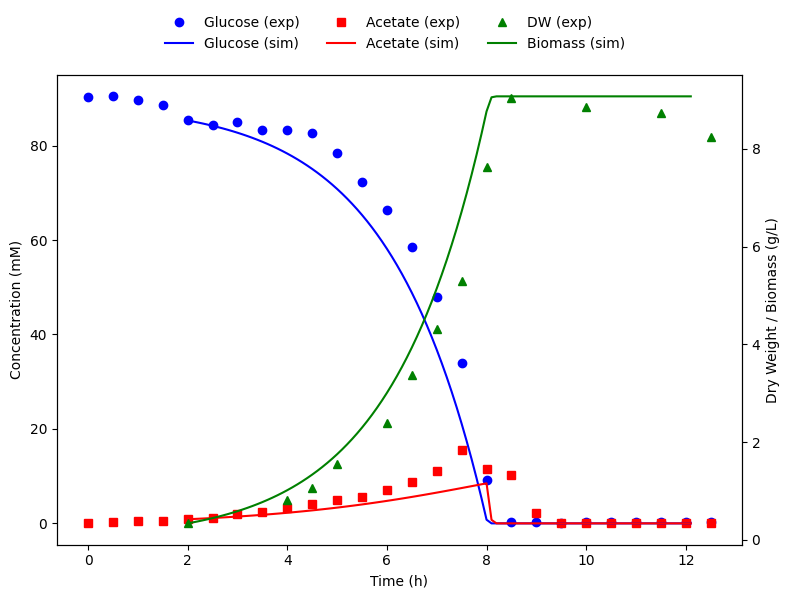

In [369]:
plot_exo_vs_sim(hist, exp_data)